# Etapa 1

El objetivo de este notebook es mostrar cuales son las variables que mas influyen en la decision de un cliente para definir si el servicio prestado por Airalpes es satisfactorio o insatisfactorio. De entrada identificamos que es un problema de clasificacion por lo que haremos el analisis para al final construir un arbol de decision que nos indicara cuales son las variables con mayor significancia.

In [1]:
pip install ydata-profiling

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Primero importamos las librerias que usaremos para realizar el modelo

# Librerías para manejo de datos
import pandas as pd
pd.set_option('display.max_columns', 25) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar
import numpy as np
np.random.seed(3301)
import pandas as pd
# Para preparar los datos
from sklearn.preprocessing import LabelEncoder
# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 
#Librerías para la visualización
import matplotlib as mplt
import matplotlib.pyplot as plt
# Seaborn
import seaborn as sns 
from sklearn import tree
# Para la serialización del modelo
import pickle

import ydata_profiling
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

%matplotlib inline

In [3]:
# Ahora importamos nuestros datos
df = pd.read_csv('data/aplesair.csv',sep=';', encoding='utf-8', index_col=0)

# Entendimiento de los datos

Para el entendimiento de los datos usaremos la libreria de ydata_profiling de pandas que nos ayuda a indentificar el tipo de variables que tenemos y su composicion

In [4]:
airalpes = df
airalpes.head()

Sexo TipoCliente  Edad TipoViaje      Clase  DistanciaREconomicarrida  \
id                                                                             
63296     M   Frecuente    16  Negocios  Ejecutiva                      3192   
73453     F   Frecuente     7  Personal  Economica                      1012   
1316      F   Frecuente    39  Negocios  Ejecutiva                      2204   
128845    F   Frecuente     9  Personal  Economica                      2475   
32338     M   Frecuente    56  Negocios  Ejecutiva                      3344   

        SatServicioWifi SatPuntualidad  SatComidaBebidas  ComodidadSilla  \
id                                                                         
63296                 3              2               300               3   
73453                 3              5                 5               2   
1316                  1              1                 3               4   
128845                4              2                 4               5   
32338                 0              5                 3               4   

        SatEntretenimiento  SatServicioAbordo  NivelLimpieza  \
id                                                             
63296                    3                  3              3   
73453                    5                  2              5   
1316                     4                  4              3   
128845                   1                  5              5   
32338                    2                  2              5   

        MinRetrasoSalida           satisfaccion  
id                                               
63296                 31  neutro o insatisfecho  
73453                 26  neutro o insatisfecho  
1316                   0             satisfecho  
128845                 0  neutro o insatisfecho  
32338                  0             satisfecho

In [5]:
profile = ydata_profiling.ProfileReport(airalpes)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Limpieza y preparacion de los datos

Como podemos observar con la caracterizacion de los datos, no tenemos nulos, pero si tenemos unos comportamientos un poco extraños con algunas columnas. En el caso de la columna "Sexo" encontramos que hay diferentes formatos por lo que debemos cambiarlo y la columna de SatPuntualidad es categorica pero muestra valores que deberian ser numericos. Por lo que haremos el respectivo Cambio.

In [6]:
# Realizaremos el cambio de los valores extraordinarios en la columna sexo y se asignaran M o F o None
airalpes['Sexo'] = airalpes['Sexo'] .replace(['Male', 'Female',' '],['M','F', None])

In [7]:
# Realizaremos el cambio de los valores categoricos a numericos de la columna SatPuntualidad por sus respectivos valores
airalpes['SatPuntualidad'] = airalpes['SatPuntualidad'].replace(['0','1','2','3','4','5','Cuatro'],[0,1,2,3,4,5,4])

Una vez corregidos los datos, realizamos la verificacion de nulos y duplicados en el modelo

In [8]:
airalpes.isna().sum()

Sexo                        14
TipoCliente                  0
Edad                         0
TipoViaje                    0
Clase                        0
DistanciaREconomicarrida     0
SatServicioWifi              0
SatPuntualidad               0
SatComidaBebidas             0
ComodidadSilla               0
SatEntretenimiento           0
SatServicioAbordo            0
NivelLimpieza                0
MinRetrasoSalida             0
satisfaccion                 0
dtype: int64

In [9]:
# Una vez identificados eliminamos lo valores nulos y duplciados
airalpes = airalpes.dropna()

airalpes = airalpes.drop_duplicates()

In [10]:
airalpes.shape

(986, 15)

En este caso utilizamos la eliminacion de valores nulos y duplicados porque eran una pequeña fraccion de los datos. En este punto, para realizar tareas de clasficiacion debemos tenes nuestros datos en variables numericas. Por lo que realizaremos el cambio correspondiente. 

In [11]:
# Reemplazaremos los valores de las columnas clase y satisfaccion por valores numericos secuenciales
airalpes['Clase'] = airalpes['Clase'].replace(['MuyEconomicanomica','Economica','Ejecutiva'],[0,1,2])
airalpes['satisfaccion'] = airalpes['satisfaccion'].replace(['neutro o insatisfecho','satisfecho'],[0,1])

In [26]:
oneHotCat = ['Sexo','TipoViaje','TipoCliente']

onehotEncoder = Pipeline([
    ('onehot_encoder', OneHotEncoder())
])

In [27]:
pipeline = Pipeline([
    ('tranformer', ColumnTransformer([
        ('keep', 'passthrough', ['Edad','Clase','DistanciaREconomicarrida','SatServicioWifi','SatComidaBebidas', 'ComodidadSilla', 'SatEntretenimiento','SatServicioAbordo', 'NivelLimpieza', 'MinRetrasoSalida','satisfaccion']),
        ('onehot_encode', onehotEncoder,oneHotCat)
    ]))
])

df_airalpes = pipeline.fit_transform(airalpes)
df_airalpes = pd.DataFrame(df_airalpes)
df_airalpes

0    1       2    3      4    5    6    7    8     9    10   11   12  \
0    16.0  2.0  3192.0  3.0  300.0  3.0  3.0  3.0  3.0  31.0  0.0  0.0  1.0   
1     7.0  1.0  1012.0  3.0    5.0  2.0  5.0  2.0  5.0  26.0  0.0  1.0  0.0   
2    39.0  2.0  2204.0  1.0    3.0  4.0  4.0  4.0  3.0   0.0  1.0  1.0  0.0   
3     9.0  1.0  2475.0  4.0    4.0  5.0  1.0  5.0  5.0   0.0  0.0  1.0  0.0   
4    56.0  2.0  3344.0  0.0    3.0  4.0  2.0  2.0  5.0   0.0  1.0  0.0  1.0   
..    ...  ...     ...  ...    ...  ...  ...  ...  ...   ...  ...  ...  ...   
981  59.0  2.0  3203.0  5.0    4.0  5.0  2.0  2.0  3.0   7.0  1.0  1.0  0.0   
982  40.0  1.0   933.0  5.0    1.0  1.0  1.0  3.0  1.0   0.0  1.0  1.0  0.0   
983  17.0  1.0   250.0  5.0    2.0  2.0  2.0  4.0  2.0   0.0  1.0  0.0  1.0   
984  36.0  1.0   946.0  2.0    1.0  1.0  1.0  3.0  1.0   0.0  0.0  1.0  0.0   
985  28.0  1.0   239.0  2.0    5.0  5.0  5.0  5.0  5.0  31.0  0.0  0.0  1.0   

      13   14   15   16  
0    1.0  0.0  0.0  1.0  
1    0.0  1.0  0.0  1.0  
2    1.0  0.0  0.0  1.0  
3    0.0  1.0  0.0  1.0  
4    1.0  0.0  0.0  1.0  
..   ...  ...  ...  ...  
981  1.0  0.0  0.0  1.0  
982  0.0  1.0  0.0  1.0  
983  1.0  0.0  1.0  0.0  
984  0.0  1.0  0.0  1.0  
985  0.0  1.0  0.0  1.0  

[986 rows x 17 columns]

In [28]:
features = ['Edad','Clase','DistanciaREconomicarrida','SatServicioWifi',
            'SatComidaBebidas', 'ComodidadSilla', 'SatEntretenimiento','SatServicioAbordo',
            'NivelLimpieza', 'MinRetrasoSalida','satisfaccion','Sexo_M','Sexo_F',
            'TipoViaje_Negocios','TipoViaje_Personal','TipoCliente_Frecuente','TipoCliente_Esporadico',
            ]

df_airalpes.columns = features
df_airalpes

Edad  Clase  DistanciaREconomicarrida  SatServicioWifi  SatComidaBebidas  \
0    16.0    2.0                    3192.0              3.0             300.0   
1     7.0    1.0                    1012.0              3.0               5.0   
2    39.0    2.0                    2204.0              1.0               3.0   
3     9.0    1.0                    2475.0              4.0               4.0   
4    56.0    2.0                    3344.0              0.0               3.0   
..    ...    ...                       ...              ...               ...   
981  59.0    2.0                    3203.0              5.0               4.0   
982  40.0    1.0                     933.0              5.0               1.0   
983  17.0    1.0                     250.0              5.0               2.0   
984  36.0    1.0                     946.0              2.0               1.0   
985  28.0    1.0                     239.0              2.0               5.0   

     ComodidadSilla  SatEntretenimiento  SatServicioAbordo  NivelLimpieza  \
0               3.0                 3.0                3.0            3.0   
1               2.0                 5.0                2.0            5.0   
2               4.0                 4.0                4.0            3.0   
3               5.0                 1.0                5.0            5.0   
4               4.0                 2.0                2.0            5.0   
..              ...                 ...                ...            ...   
981             5.0                 2.0                2.0            3.0   
982             1.0                 1.0                3.0            1.0   
983             2.0                 2.0                4.0            2.0   
984             1.0                 1.0                3.0            1.0   
985             5.0                 5.0                5.0            5.0   

     MinRetrasoSalida  satisfaccion  Sexo_M  Sexo_F  TipoViaje_Negocios  \
0                31.0           0.0     0.0     1.0                 1.0   
1                26.0           0.0     1.0     0.0                 0.0   
2                 0.0           1.0     1.0     0.0                 1.0   
3                 0.0           0.0     1.0     0.0                 0.0   
4                 0.0           1.0     0.0     1.0                 1.0   
..                ...           ...     ...     ...                 ...   
981               7.0           1.0     1.0     0.0                 1.0   
982               0.0           1.0     1.0     0.0                 0.0   
983               0.0           1.0     0.0     1.0                 1.0   
984               0.0           0.0     1.0     0.0                 0.0   
985              31.0           0.0     0.0     1.0                 0.0   

     TipoViaje_Personal  TipoCliente_Frecuente  TipoCliente_Esporadico  
0                   0.0                    0.0                     1.0  
1                   1.0                    0.0                     1.0  
2                   0.0                    0.0                     1.0  
3                   1.0                    0.0                     1.0  
4                   0.0                    0.0                     1.0  
..                  ...                    ...                     ...  
981                 0.0                    0.0                     1.0  
982                 1.0                    0.0                     1.0  
983                 0.0                    1.0                     0.0  
984                 1.0                    0.0                     1.0  
985                 1.0                    0.0                     1.0  

[986 rows x 17 columns]

In [29]:
df_airalpes.isna().sum()

Edad                        0
Clase                       0
DistanciaREconomicarrida    0
SatServicioWifi             0
SatComidaBebidas            0
ComodidadSilla              0
SatEntretenimiento          0
SatServicioAbordo           0
NivelLimpieza               0
MinRetrasoSalida            0
satisfaccion                0
Sexo_M                      0
Sexo_F                      0
TipoViaje_Negocios          0
TipoViaje_Personal          0
TipoCliente_Frecuente       0
TipoCliente_Esporadico      0
dtype: int64

In [30]:
# Ahora describiremos la variable objetivo
df_airalpes['satisfaccion'].describe()

count    986.000000
mean       0.433063
std        0.495751
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: satisfaccion, dtype: float64

c:\Users\jm200\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\jm200\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


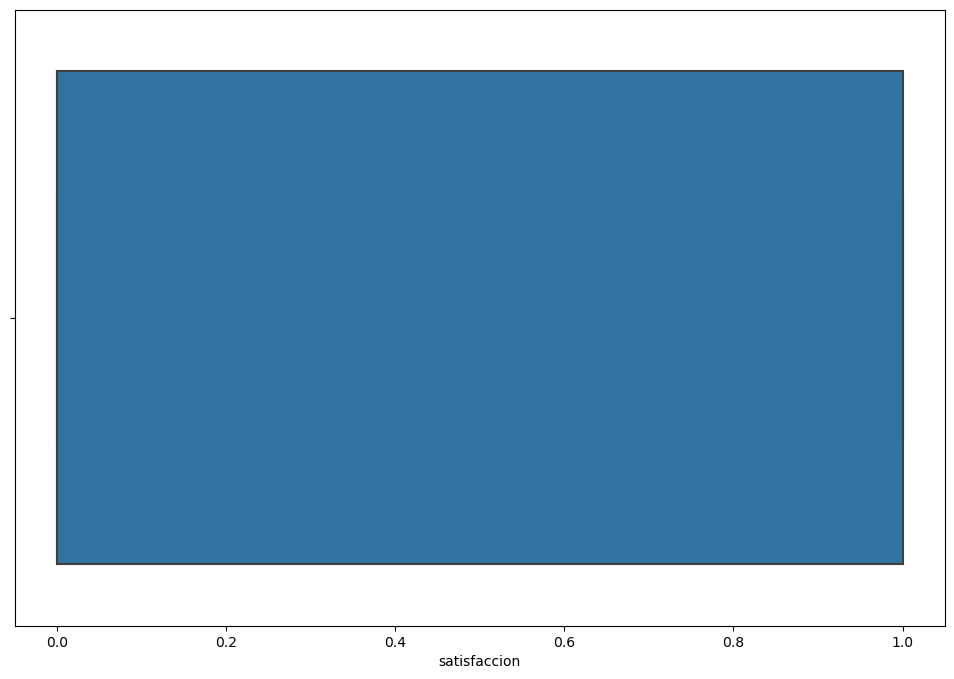

In [35]:
fig=plt.figure(figsize=(12,8))
ax = sns.boxplot("satisfaccion", data=df_airalpes, orient="v")

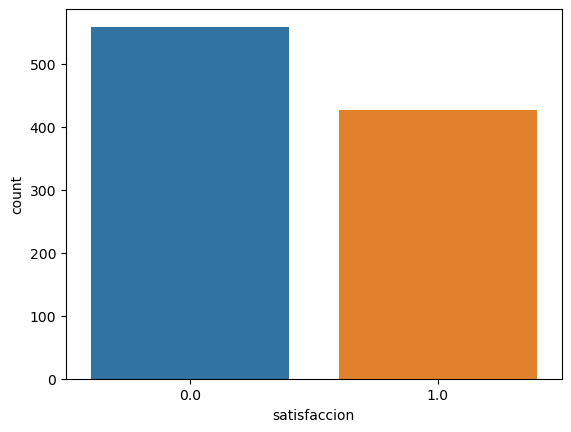

In [36]:
ax = sns.countplot(x='satisfaccion',data=df_airalpes)

Podemos determinar con lo anterior que hay mas gente insatisfecha dentro de nuestros datos. En este punto consideramos que todos los factores presentados pueden representar un nivel de significancia para el modelo por lo que no eliminaremos ninguna columna.

# Construccion del modelo

Para la construccion del modelo separaremos nuestras variables

In [37]:
# Se selecciona la variable bjetivo
y = df_airalpes['satisfaccion']

# Se elmina la variable de satisfaccion del conjunto de datos
x = df_airalpes.drop(['satisfaccion'], axis=1)

In [38]:
# Se dividen los datos de entrenamiento y de test
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=0)

In [72]:
arbol = DecisionTreeClassifier(criterion="entropy",max_depth=5 ,random_state=0)

In [73]:
# Entrenamos el arbol de decision con los datos de entrenamiento
arbol = arbol.fit(x_train,y_train)

In [74]:
# Determinamos las predicciones del moedlo sobre el conjunto test
y_pred = arbol.predict(x_test)

# Interpretacion

Primero generaremos una matriz de confusion para determinar la certeza de la prediccion y la mostramos en pantalla

c:\Users\jm200\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


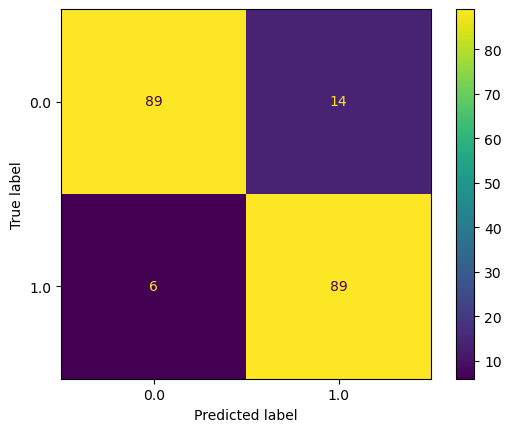

In [75]:
confusion_matrix(y_test,y_pred)
plot_confusion_matrix(arbol, x_test, y_test)  
plt.show() 

In [76]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

Exactitud: 0.90
Recall: 0.9368421052631579
Precisión: 0.8640776699029126
Puntuación F1: 0.898989898989899


In [77]:
# Generamos un reporte para tener una vision un poco mas amplia
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.86      0.90       103
         1.0       0.86      0.94      0.90        95

    accuracy                           0.90       198
   macro avg       0.90      0.90      0.90       198
weighted avg       0.90      0.90      0.90       198



In [78]:
# Obtenemos los valores de nivel de importancia de cada una de las variables
importancia = arbol.feature_importances_
importancia

array([0.        , 0.25059646, 0.        , 0.42050234, 0.        ,
       0.08224247, 0.        , 0.07011839, 0.01343781, 0.01864614,
       0.        , 0.        , 0.0668043 , 0.00623102, 0.06519373,
       0.00622733])

In [79]:
importancia_atributo = pd.DataFrame(data={"Atributo": x_train.columns,"Importancia": importancia})
importancia_atributo = importancia_atributo.sort_values(by='Importancia', ascending=False).reset_index(drop=True)
importancia_atributo

Atributo  Importancia
0            SatServicioWifi     0.420502
1                      Clase     0.250596
2             ComodidadSilla     0.082242
3          SatServicioAbordo     0.070118
4         TipoViaje_Negocios     0.066804
5      TipoCliente_Frecuente     0.065194
6           MinRetrasoSalida     0.018646
7              NivelLimpieza     0.013438
8         TipoViaje_Personal     0.006231
9     TipoCliente_Esporadico     0.006227
10                      Edad     0.000000
11  DistanciaREconomicarrida     0.000000
12          SatComidaBebidas     0.000000
13        SatEntretenimiento     0.000000
14                    Sexo_M     0.000000
15                    Sexo_F     0.000000

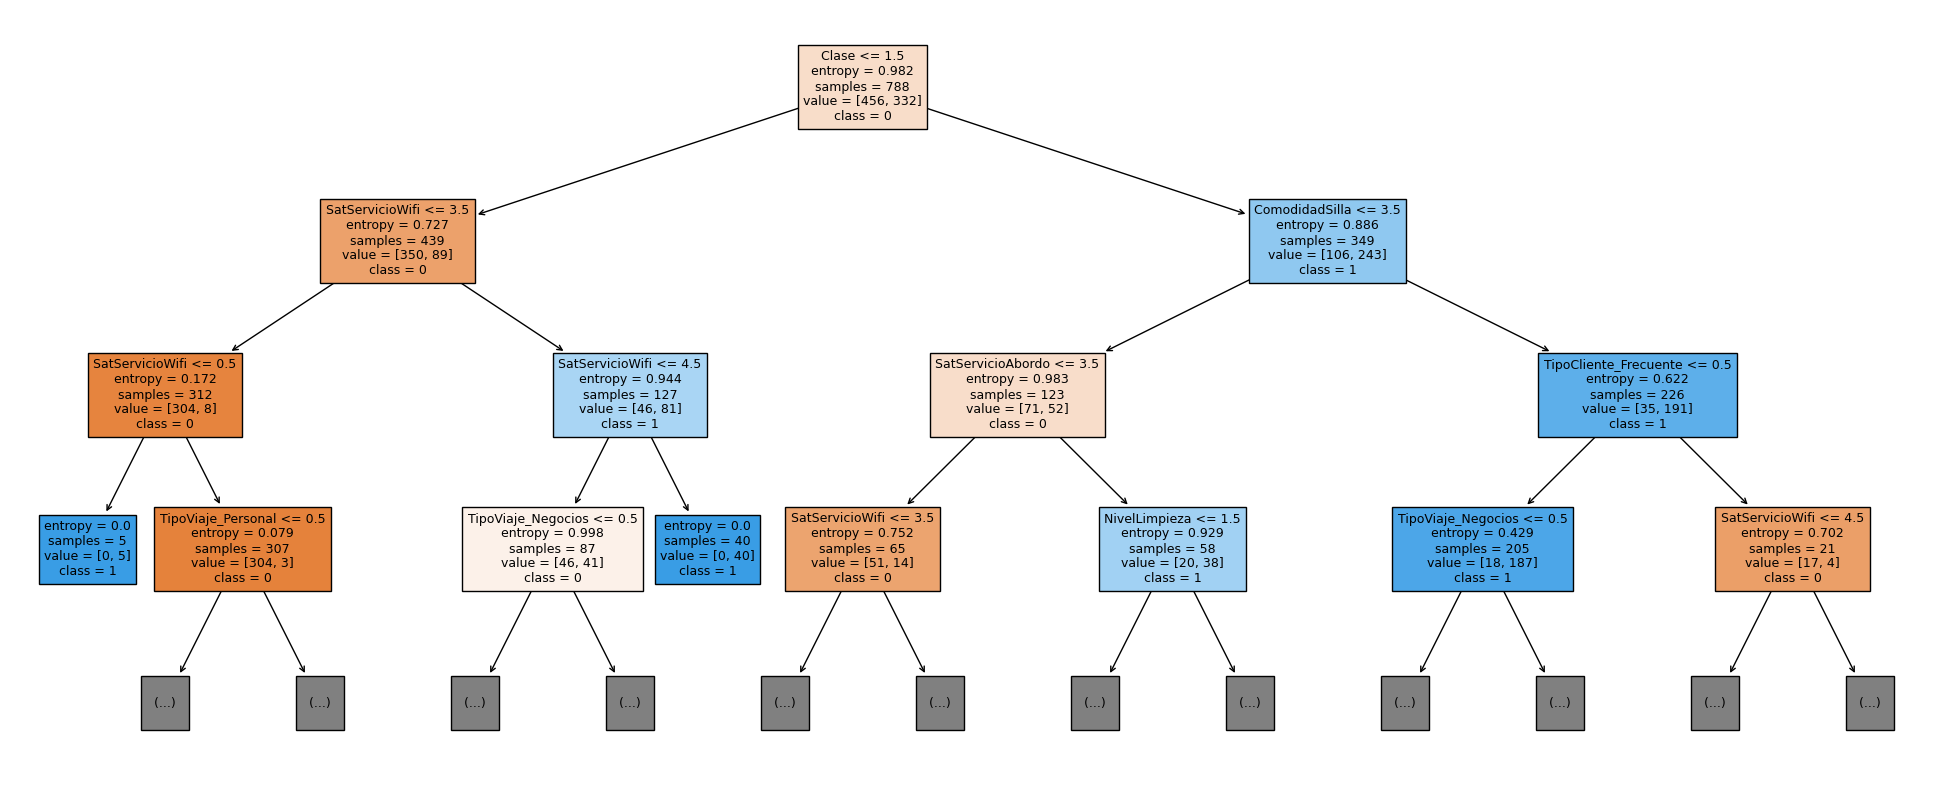

In [80]:
fig = plt.figure(figsize=(25,10))
_ = tree.plot_tree(arbol, max_depth=3, feature_names=x.columns, class_names=["0", "1"], filled=True, fontsize=9)

In [81]:
# Ahora guardamos la figura
fig.savefig("decission_tree_airalpes.png")

Como podemos observar, una ves realizado nuestro modelo, encontramos que el servicioWifi es una variable que los clientes consideran muy importante a la hora de decidir si quedo satisfecho con  el servicio ofrecido por la empresa airalpes. Ademas, la clase en la que se viaja y la comodidad de la silla son factores determinantes que pueden hacer que el cliente quede satisfecho o insatisfecho. De esta forma, despues de analizar los resultados, recomendamos implementar en mayor medida un buen servicio de Wifi abordo de las aeornaves, junto con una mejora sustancial de los asientos, principalmente los de clase economica y muy economica. Con estos cambios se deberia ver una mejora en la satisfaccion de los clientes.